<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:26] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


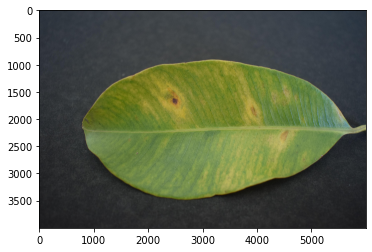

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

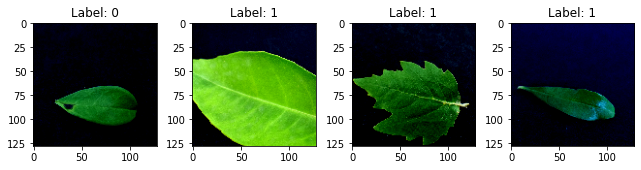

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:33] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:35] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2614455707943284 samples/sec                   batch loss = 1.069804310798645 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2713188492094465 samples/sec                   batch loss = 0.9169608950614929 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2691455674657508 samples/sec                   batch loss = 0.314588338136673 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.265770415877598 samples/sec                   batch loss = 0.4601277709007263 | accuracy = 0.6625


Epoch[1] Batch[25] Speed: 1.2736720638429677 samples/sec                   batch loss = 0.5626915693283081 | accuracy = 0.67


Epoch[1] Batch[30] Speed: 1.2742473572638418 samples/sec                   batch loss = 0.7159780263900757 | accuracy = 0.6416666666666667


Epoch[1] Batch[35] Speed: 1.2686092110111473 samples/sec                   batch loss = 0.3465772569179535 | accuracy = 0.6714285714285714


Epoch[1] Batch[40] Speed: 1.2688337173112385 samples/sec                   batch loss = 0.6045684218406677 | accuracy = 0.66875


Epoch[1] Batch[45] Speed: 1.2696490358979808 samples/sec                   batch loss = 0.7029847502708435 | accuracy = 0.6611111111111111


Epoch[1] Batch[50] Speed: 1.2732755523464565 samples/sec                   batch loss = 0.42065000534057617 | accuracy = 0.66


Epoch[1] Batch[55] Speed: 1.2741375209341055 samples/sec                   batch loss = 0.6102972030639648 | accuracy = 0.6681818181818182


Epoch[1] Batch[60] Speed: 1.27302783385611 samples/sec                   batch loss = 0.8436008095741272 | accuracy = 0.6583333333333333


Epoch[1] Batch[65] Speed: 1.2702252199868203 samples/sec                   batch loss = 1.2285288572311401 | accuracy = 0.6538461538461539


Epoch[1] Batch[70] Speed: 1.2728672161742567 samples/sec                   batch loss = 0.5240789651870728 | accuracy = 0.6571428571428571


Epoch[1] Batch[75] Speed: 1.2783689754961227 samples/sec                   batch loss = 0.8210256099700928 | accuracy = 0.65


Epoch[1] Batch[80] Speed: 1.2757693032428927 samples/sec                   batch loss = 1.0019170045852661 | accuracy = 0.64375


Epoch[1] Batch[85] Speed: 1.2650516359424766 samples/sec                   batch loss = 0.3996320366859436 | accuracy = 0.6441176470588236


Epoch[1] Batch[90] Speed: 1.2692711570713615 samples/sec                   batch loss = 0.9497107863426208 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2738744746009314 samples/sec                   batch loss = 0.6360747218132019 | accuracy = 0.6368421052631579


Epoch[1] Batch[100] Speed: 1.2677278811081962 samples/sec                   batch loss = 0.5966545939445496 | accuracy = 0.6375


Epoch[1] Batch[105] Speed: 1.2684709968676118 samples/sec                   batch loss = 0.42784836888313293 | accuracy = 0.6309523809523809


Epoch[1] Batch[110] Speed: 1.2666632742442814 samples/sec                   batch loss = 1.6206845045089722 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.269921874733891 samples/sec                   batch loss = 0.7051157355308533 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.273020589251389 samples/sec                   batch loss = 0.537523627281189 | accuracy = 0.6395833333333333


Epoch[1] Batch[125] Speed: 1.2767231564555115 samples/sec                   batch loss = 0.5258845090866089 | accuracy = 0.644


Epoch[1] Batch[130] Speed: 1.2714475672747538 samples/sec                   batch loss = 0.4116465747356415 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.27541608422123 samples/sec                   batch loss = 0.5247018933296204 | accuracy = 0.65


Epoch[1] Batch[140] Speed: 1.2736484711708367 samples/sec                   batch loss = 0.35935261845588684 | accuracy = 0.6446428571428572


Epoch[1] Batch[145] Speed: 1.275399892432043 samples/sec                   batch loss = 1.0424120426177979 | accuracy = 0.6482758620689655


Epoch[1] Batch[150] Speed: 1.2690710703932413 samples/sec                   batch loss = 0.4220496416091919 | accuracy = 0.6483333333333333


Epoch[1] Batch[155] Speed: 1.2720653140301152 samples/sec                   batch loss = 1.2975717782974243 | accuracy = 0.6451612903225806


Epoch[1] Batch[160] Speed: 1.2763893155637762 samples/sec                   batch loss = 0.24235859513282776 | accuracy = 0.64375


Epoch[1] Batch[165] Speed: 1.2761521294929739 samples/sec                   batch loss = 0.3072686791419983 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.2734876968493103 samples/sec                   batch loss = 0.5414145588874817 | accuracy = 0.6397058823529411


Epoch[1] Batch[175] Speed: 1.2785131549056834 samples/sec                   batch loss = 0.6588838696479797 | accuracy = 0.6371428571428571


Epoch[1] Batch[180] Speed: 1.271794349324518 samples/sec                   batch loss = 1.5397789478302002 | accuracy = 0.6402777777777777


Epoch[1] Batch[185] Speed: 1.2835994489858609 samples/sec                   batch loss = 0.5347269773483276 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.2717193481834363 samples/sec                   batch loss = 0.4364199936389923 | accuracy = 0.6434210526315789


Epoch[1] Batch[195] Speed: 1.2757574679175119 samples/sec                   batch loss = 0.794209361076355 | accuracy = 0.6461538461538462


Epoch[1] Batch[200] Speed: 1.2689909190070185 samples/sec                   batch loss = 0.42837151885032654 | accuracy = 0.6475


Epoch[1] Batch[205] Speed: 1.2698531494329293 samples/sec                   batch loss = 0.31029149889945984 | accuracy = 0.6475609756097561


Epoch[1] Batch[210] Speed: 1.2749034791870906 samples/sec                   batch loss = 0.6668769717216492 | accuracy = 0.6452380952380953


Epoch[1] Batch[215] Speed: 1.270739844039654 samples/sec                   batch loss = 0.7419827580451965 | accuracy = 0.6406976744186047


Epoch[1] Batch[220] Speed: 1.2784765224606085 samples/sec                   batch loss = 0.6842331290245056 | accuracy = 0.6443181818181818


Epoch[1] Batch[225] Speed: 1.2757886088760193 samples/sec                   batch loss = 0.49291476607322693 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2777949185742774 samples/sec                   batch loss = 0.66092848777771 | accuracy = 0.6467391304347826


Epoch[1] Batch[235] Speed: 1.2759132849480674 samples/sec                   batch loss = 0.724902331829071 | accuracy = 0.65


Epoch[1] Batch[240] Speed: 1.2752359616015791 samples/sec                   batch loss = 1.5855581760406494 | accuracy = 0.646875


Epoch[1] Batch[245] Speed: 1.2713518933517949 samples/sec                   batch loss = 0.41981905698776245 | accuracy = 0.6479591836734694


Epoch[1] Batch[250] Speed: 1.272867023032474 samples/sec                   batch loss = 0.5820330381393433 | accuracy = 0.651


Epoch[1] Batch[255] Speed: 1.273293043137265 samples/sec                   batch loss = 1.3474074602127075 | accuracy = 0.6490196078431373


Epoch[1] Batch[260] Speed: 1.2732314892799341 samples/sec                   batch loss = 1.0149033069610596 | accuracy = 0.6480769230769231


Epoch[1] Batch[265] Speed: 1.2669471731288926 samples/sec                   batch loss = 0.9516267776489258 | accuracy = 0.6490566037735849


Epoch[1] Batch[270] Speed: 1.2742100011096125 samples/sec                   batch loss = 0.8304929137229919 | accuracy = 0.65


Epoch[1] Batch[275] Speed: 1.2756704559149645 samples/sec                   batch loss = 0.69578617811203 | accuracy = 0.65


Epoch[1] Batch[280] Speed: 1.2691978934476054 samples/sec                   batch loss = 1.578798770904541 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.2721131546650397 samples/sec                   batch loss = 0.4991829991340637 | accuracy = 0.6491228070175439


Epoch[1] Batch[290] Speed: 1.2681561230735832 samples/sec                   batch loss = 0.6238296031951904 | accuracy = 0.6491379310344828


Epoch[1] Batch[295] Speed: 1.2652351902948955 samples/sec                   batch loss = 0.5189830660820007 | accuracy = 0.6516949152542373


Epoch[1] Batch[300] Speed: 1.268950703144086 samples/sec                   batch loss = 0.674069344997406 | accuracy = 0.65


Epoch[1] Batch[305] Speed: 1.2704299036433313 samples/sec                   batch loss = 0.6379236578941345 | accuracy = 0.6491803278688525


Epoch[1] Batch[310] Speed: 1.2727633143613601 samples/sec                   batch loss = 0.7009826898574829 | accuracy = 0.6491935483870968


Epoch[1] Batch[315] Speed: 1.2756968395715351 samples/sec                   batch loss = 1.4321188926696777 | accuracy = 0.65


Epoch[1] Batch[320] Speed: 1.2689875595891549 samples/sec                   batch loss = 0.7816210389137268 | accuracy = 0.65078125


Epoch[1] Batch[325] Speed: 1.2717340006673543 samples/sec                   batch loss = 0.3056296706199646 | accuracy = 0.6515384615384615


Epoch[1] Batch[330] Speed: 1.2745158827764351 samples/sec                   batch loss = 0.6095887422561646 | accuracy = 0.6522727272727272


Epoch[1] Batch[335] Speed: 1.2686483499806156 samples/sec                   batch loss = 1.1538840532302856 | accuracy = 0.6507462686567164


Epoch[1] Batch[340] Speed: 1.2720219133413722 samples/sec                   batch loss = 1.0054856538772583 | accuracy = 0.6507352941176471


Epoch[1] Batch[345] Speed: 1.2650094755733488 samples/sec                   batch loss = 0.676114559173584 | accuracy = 0.6514492753623189


Epoch[1] Batch[350] Speed: 1.273093618640637 samples/sec                   batch loss = 0.4546581208705902 | accuracy = 0.6521428571428571


Epoch[1] Batch[355] Speed: 1.2775370724271269 samples/sec                   batch loss = 0.27909189462661743 | accuracy = 0.6549295774647887


Epoch[1] Batch[360] Speed: 1.2718138240751704 samples/sec                   batch loss = 0.9162078499794006 | accuracy = 0.6534722222222222


Epoch[1] Batch[365] Speed: 1.269416365023062 samples/sec                   batch loss = 0.7274428606033325 | accuracy = 0.65


Epoch[1] Batch[370] Speed: 1.2682008900498272 samples/sec                   batch loss = 0.6832027435302734 | accuracy = 0.65


Epoch[1] Batch[375] Speed: 1.2733745121020252 samples/sec                   batch loss = 0.4892246723175049 | accuracy = 0.65


Epoch[1] Batch[380] Speed: 1.268941201438967 samples/sec                   batch loss = 0.6029958128929138 | accuracy = 0.6506578947368421


Epoch[1] Batch[385] Speed: 1.2629455331734039 samples/sec                   batch loss = 0.29585927724838257 | accuracy = 0.6512987012987013


Epoch[1] Batch[390] Speed: 1.2664598980036208 samples/sec                   batch loss = 0.36591842770576477 | accuracy = 0.65


Epoch[1] Batch[395] Speed: 1.261927855241431 samples/sec                   batch loss = 0.5149610042572021 | accuracy = 0.6468354430379747


Epoch[1] Batch[400] Speed: 1.2715784316638281 samples/sec                   batch loss = 0.32779648900032043 | accuracy = 0.64875


Epoch[1] Batch[405] Speed: 1.2680619022709254 samples/sec                   batch loss = 0.7237082123756409 | accuracy = 0.6506172839506172


Epoch[1] Batch[410] Speed: 1.2794282828176526 samples/sec                   batch loss = 0.4914643466472626 | accuracy = 0.649390243902439


Epoch[1] Batch[415] Speed: 1.2746582258842776 samples/sec                   batch loss = 0.5333977341651917 | accuracy = 0.65


Epoch[1] Batch[420] Speed: 1.2735525624212627 samples/sec                   batch loss = 0.7921537160873413 | accuracy = 0.6494047619047619


Epoch[1] Batch[425] Speed: 1.2739031054908336 samples/sec                   batch loss = 0.21010348200798035 | accuracy = 0.6517647058823529


Epoch[1] Batch[430] Speed: 1.2706703565139894 samples/sec                   batch loss = 0.8084440231323242 | accuracy = 0.6523255813953488


Epoch[1] Batch[435] Speed: 1.2710269215293977 samples/sec                   batch loss = 0.45500802993774414 | accuracy = 0.6517241379310345


Epoch[1] Batch[440] Speed: 1.2725946548830231 samples/sec                   batch loss = 0.4542334973812103 | accuracy = 0.6522727272727272


Epoch[1] Batch[445] Speed: 1.2714051722191126 samples/sec                   batch loss = 0.8502374887466431 | accuracy = 0.653370786516854


Epoch[1] Batch[450] Speed: 1.2741501003464775 samples/sec                   batch loss = 0.39032676815986633 | accuracy = 0.655


Epoch[1] Batch[455] Speed: 1.2701116528613103 samples/sec                   batch loss = 0.32935312390327454 | accuracy = 0.656043956043956


Epoch[1] Batch[460] Speed: 1.271291394012891 samples/sec                   batch loss = 0.3640958070755005 | accuracy = 0.6581521739130435


Epoch[1] Batch[465] Speed: 1.2750273040196092 samples/sec                   batch loss = 1.0265531539916992 | accuracy = 0.6591397849462366


Epoch[1] Batch[470] Speed: 1.2767756233285676 samples/sec                   batch loss = 0.5016711950302124 | accuracy = 0.6590425531914894


Epoch[1] Batch[475] Speed: 1.266927942805702 samples/sec                   batch loss = 0.5405868291854858 | accuracy = 0.6594736842105263


Epoch[1] Batch[480] Speed: 1.2633275500277519 samples/sec                   batch loss = 0.8085948824882507 | accuracy = 0.6604166666666667


Epoch[1] Batch[485] Speed: 1.2621262653166345 samples/sec                   batch loss = 0.5581148862838745 | accuracy = 0.6623711340206185


Epoch[1] Batch[490] Speed: 1.2636432662810886 samples/sec                   batch loss = 0.1403689831495285 | accuracy = 0.6642857142857143


Epoch[1] Batch[495] Speed: 1.2672428769585475 samples/sec                   batch loss = 0.46606260538101196 | accuracy = 0.6651515151515152


Epoch[1] Batch[500] Speed: 1.2709158104300113 samples/sec                   batch loss = 0.727481484413147 | accuracy = 0.666


Epoch[1] Batch[505] Speed: 1.2748917567990439 samples/sec                   batch loss = 0.7231756448745728 | accuracy = 0.6658415841584159


Epoch[1] Batch[510] Speed: 1.269307551976291 samples/sec                   batch loss = 0.36011216044425964 | accuracy = 0.6676470588235294


Epoch[1] Batch[515] Speed: 1.2682866942661812 samples/sec                   batch loss = 0.3622593879699707 | accuracy = 0.6689320388349514


Epoch[1] Batch[520] Speed: 1.277256965155627 samples/sec                   batch loss = 0.47490593791007996 | accuracy = 0.6682692307692307


Epoch[1] Batch[525] Speed: 1.2678111303875235 samples/sec                   batch loss = 0.2798740565776825 | accuracy = 0.6685714285714286


Epoch[1] Batch[530] Speed: 1.269221705598068 samples/sec                   batch loss = 0.3503691554069519 | accuracy = 0.6674528301886793


Epoch[1] Batch[535] Speed: 1.2695949433585723 samples/sec                   batch loss = 0.8738833665847778 | accuracy = 0.6686915887850468


Epoch[1] Batch[540] Speed: 1.2679179622220178 samples/sec                   batch loss = 0.6838098764419556 | accuracy = 0.6703703703703704


Epoch[1] Batch[545] Speed: 1.2706706452275975 samples/sec                   batch loss = 0.4963565468788147 | accuracy = 0.6706422018348623


Epoch[1] Batch[550] Speed: 1.2709558621052233 samples/sec                   batch loss = 0.5243943929672241 | accuracy = 0.6713636363636364


Epoch[1] Batch[555] Speed: 1.2738595793090572 samples/sec                   batch loss = 0.8030187487602234 | accuracy = 0.6707207207207208


Epoch[1] Batch[560] Speed: 1.2691583365275587 samples/sec                   batch loss = 0.4412840008735657 | accuracy = 0.6723214285714286


Epoch[1] Batch[565] Speed: 1.2730382662317687 samples/sec                   batch loss = 0.30958253145217896 | accuracy = 0.6734513274336283


Epoch[1] Batch[570] Speed: 1.270660540329377 samples/sec                   batch loss = 0.5827869176864624 | accuracy = 0.6723684210526316


Epoch[1] Batch[575] Speed: 1.2647898483394995 samples/sec                   batch loss = 0.82538902759552 | accuracy = 0.672608695652174


Epoch[1] Batch[580] Speed: 1.2688019553985213 samples/sec                   batch loss = 0.6205481290817261 | accuracy = 0.6728448275862069


Epoch[1] Batch[585] Speed: 1.2708376399128627 samples/sec                   batch loss = 0.19914129376411438 | accuracy = 0.6752136752136753


Epoch[1] Batch[590] Speed: 1.275040773116039 samples/sec                   batch loss = 0.18222151696681976 | accuracy = 0.6775423728813559


Epoch[1] Batch[595] Speed: 1.2747848120732885 samples/sec                   batch loss = 0.41755276918411255 | accuracy = 0.6773109243697479


Epoch[1] Batch[600] Speed: 1.2743696994836884 samples/sec                   batch loss = 0.453943133354187 | accuracy = 0.6795833333333333


Epoch[1] Batch[605] Speed: 1.2762975569147819 samples/sec                   batch loss = 0.5818795561790466 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2730723658376033 samples/sec                   batch loss = 0.8038254380226135 | accuracy = 0.6815573770491803


Epoch[1] Batch[615] Speed: 1.2744530488942476 samples/sec                   batch loss = 0.5702528357505798 | accuracy = 0.6808943089430894


Epoch[1] Batch[620] Speed: 1.2728738796016563 samples/sec                   batch loss = 0.3748076558113098 | accuracy = 0.6810483870967742


Epoch[1] Batch[625] Speed: 1.2656884847066558 samples/sec                   batch loss = 0.32658979296684265 | accuracy = 0.6812


Epoch[1] Batch[630] Speed: 1.2674116526791357 samples/sec                   batch loss = 0.16360996663570404 | accuracy = 0.6821428571428572


Epoch[1] Batch[635] Speed: 1.2684963162893637 samples/sec                   batch loss = 0.39258071780204773 | accuracy = 0.6818897637795276


Epoch[1] Batch[640] Speed: 1.2662191245607874 samples/sec                   batch loss = 0.7180334329605103 | accuracy = 0.683203125


Epoch[1] Batch[645] Speed: 1.2668274953828256 samples/sec                   batch loss = 0.586389422416687 | accuracy = 0.6833333333333333


Epoch[1] Batch[650] Speed: 1.2667338544666347 samples/sec                   batch loss = 0.2772039771080017 | accuracy = 0.6846153846153846


Epoch[1] Batch[655] Speed: 1.2704039297887675 samples/sec                   batch loss = 0.27945470809936523 | accuracy = 0.6862595419847328


Epoch[1] Batch[660] Speed: 1.2742954589576874 samples/sec                   batch loss = 0.3091821074485779 | accuracy = 0.6863636363636364


Epoch[1] Batch[665] Speed: 1.2709630832287153 samples/sec                   batch loss = 0.5573893785476685 | accuracy = 0.6868421052631579


Epoch[1] Batch[670] Speed: 1.27645204917484 samples/sec                   batch loss = 0.4583713114261627 | accuracy = 0.6873134328358209


Epoch[1] Batch[675] Speed: 1.2675993404065227 samples/sec                   batch loss = 0.3722463548183441 | accuracy = 0.6888888888888889


Epoch[1] Batch[680] Speed: 1.2687002512110612 samples/sec                   batch loss = 0.5452575087547302 | accuracy = 0.6882352941176471


Epoch[1] Batch[685] Speed: 1.2760080938804954 samples/sec                   batch loss = 0.5851507782936096 | accuracy = 0.6886861313868613


Epoch[1] Batch[690] Speed: 1.2715334259225926 samples/sec                   batch loss = 0.5711901783943176 | accuracy = 0.6884057971014492


Epoch[1] Batch[695] Speed: 1.2722579523819022 samples/sec                   batch loss = 0.7586154341697693 | accuracy = 0.6884892086330935


Epoch[1] Batch[700] Speed: 1.279854801628874 samples/sec                   batch loss = 0.6865312457084656 | accuracy = 0.6889285714285714


Epoch[1] Batch[705] Speed: 1.271508659668116 samples/sec                   batch loss = 0.40480780601501465 | accuracy = 0.6879432624113475


Epoch[1] Batch[710] Speed: 1.27077988462464 samples/sec                   batch loss = 0.16378559172153473 | accuracy = 0.6890845070422535


Epoch[1] Batch[715] Speed: 1.2728012616630853 samples/sec                   batch loss = 0.6399481296539307 | accuracy = 0.6898601398601398


Epoch[1] Batch[720] Speed: 1.2667484879361446 samples/sec                   batch loss = 0.6971631050109863 | accuracy = 0.6895833333333333


Epoch[1] Batch[725] Speed: 1.260414304875848 samples/sec                   batch loss = 0.8827086091041565 | accuracy = 0.6893103448275862


Epoch[1] Batch[730] Speed: 1.2678130464950488 samples/sec                   batch loss = 0.2842375338077545 | accuracy = 0.6893835616438356


Epoch[1] Batch[735] Speed: 1.2690343050872894 samples/sec                   batch loss = 0.7156953811645508 | accuracy = 0.689795918367347


Epoch[1] Batch[740] Speed: 1.2639882795734003 samples/sec                   batch loss = 0.4029020369052887 | accuracy = 0.6902027027027027


Epoch[1] Batch[745] Speed: 1.2694207832460707 samples/sec                   batch loss = 0.41590026021003723 | accuracy = 0.6902684563758389


Epoch[1] Batch[750] Speed: 1.2708730657537486 samples/sec                   batch loss = 0.4712429642677307 | accuracy = 0.6906666666666667


Epoch[1] Batch[755] Speed: 1.2617636682472917 samples/sec                   batch loss = 0.2913817763328552 | accuracy = 0.6907284768211921


Epoch[1] Batch[760] Speed: 1.2663501574255946 samples/sec                   batch loss = 0.876043438911438 | accuracy = 0.6907894736842105


Epoch[1] Batch[765] Speed: 1.268420648748323 samples/sec                   batch loss = 0.4322648346424103 | accuracy = 0.6908496732026144


Epoch[1] Batch[770] Speed: 1.260855433215917 samples/sec                   batch loss = 0.37386903166770935 | accuracy = 0.689935064935065


Epoch[1] Batch[775] Speed: 1.2635820708470509 samples/sec                   batch loss = 0.8882319927215576 | accuracy = 0.6906451612903226


Epoch[1] Batch[780] Speed: 1.2671737713436764 samples/sec                   batch loss = 0.5953879952430725 | accuracy = 0.6887820512820513


Epoch[1] Batch[785] Speed: 1.2695684272075674 samples/sec                   batch loss = 0.7636321187019348 | accuracy = 0.6888535031847134


[Epoch 1] training: accuracy=0.6894035532994924
[Epoch 1] time cost: 647.706775188446
[Epoch 1] validation: validation accuracy=0.7255555555555555


Epoch[2] Batch[5] Speed: 1.265851307053682 samples/sec                   batch loss = 0.2621351480484009 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.272120581860478 samples/sec                   batch loss = 0.42455369234085083 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2791530022501731 samples/sec                   batch loss = 0.3605438768863678 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2747808407396992 samples/sec                   batch loss = 0.5906479954719543 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2687659732796501 samples/sec                   batch loss = 0.4556192457675934 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.272247725745232 samples/sec                   batch loss = 0.7841669917106628 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2731108146096939 samples/sec                   batch loss = 0.736018717288971 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.274673333549613 samples/sec                   batch loss = 0.42204549908638 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2721991032313684 samples/sec                   batch loss = 0.25177207589149475 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.273032567042395 samples/sec                   batch loss = 1.0241973400115967 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2674637400267934 samples/sec                   batch loss = 0.3881170451641083 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2686692634591432 samples/sec                   batch loss = 0.8424711227416992 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.268146153984537 samples/sec                   batch loss = 0.5605481266975403 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2737862685983345 samples/sec                   batch loss = 0.5722492933273315 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2717703441407027 samples/sec                   batch loss = 0.4050670266151428 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2766633106207326 samples/sec                   batch loss = 0.6249875426292419 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2807821182307677 samples/sec                   batch loss = 0.41510361433029175 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2714098933467781 samples/sec                   batch loss = 0.22837583720684052 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2778982808501977 samples/sec                   batch loss = 0.9054332971572876 | accuracy = 0.7289473684210527


Epoch[2] Batch[100] Speed: 1.2797381395194862 samples/sec                   batch loss = 0.26204967498779297 | accuracy = 0.7275


Epoch[2] Batch[105] Speed: 1.2830604248904247 samples/sec                   batch loss = 0.3005673885345459 | accuracy = 0.7333333333333333


Epoch[2] Batch[110] Speed: 1.2740236401736391 samples/sec                   batch loss = 1.484611988067627 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2693284871943376 samples/sec                   batch loss = 0.2242918461561203 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2689740261144942 samples/sec                   batch loss = 0.45510056614875793 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.27603856770641 samples/sec                   batch loss = 0.2980179190635681 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.273133614475943 samples/sec                   batch loss = 0.4131528437137604 | accuracy = 0.7384615384615385


Epoch[2] Batch[135] Speed: 1.2728296512004593 samples/sec                   batch loss = 0.25841397047042847 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2787568725532477 samples/sec                   batch loss = 0.6447460651397705 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.2761495086085166 samples/sec                   batch loss = 0.4256756901741028 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.2759537492684674 samples/sec                   batch loss = 0.6473954319953918 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.2817624820873001 samples/sec                   batch loss = 0.6693739295005798 | accuracy = 0.7306451612903225


Epoch[2] Batch[160] Speed: 1.2767738743633241 samples/sec                   batch loss = 0.42998844385147095 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.2822270124770385 samples/sec                   batch loss = 0.3518356382846832 | accuracy = 0.7303030303030303


Epoch[2] Batch[170] Speed: 1.2776600471929271 samples/sec                   batch loss = 0.9468847513198853 | accuracy = 0.7264705882352941


Epoch[2] Batch[175] Speed: 1.2757094497928454 samples/sec                   batch loss = 1.0602904558181763 | accuracy = 0.7257142857142858


Epoch[2] Batch[180] Speed: 1.2792798975308242 samples/sec                   batch loss = 0.5341769456863403 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.2755440816945929 samples/sec                   batch loss = 0.21210336685180664 | accuracy = 0.7243243243243244


Epoch[2] Batch[190] Speed: 1.2749464954165364 samples/sec                   batch loss = 0.5254469513893127 | accuracy = 0.7223684210526315


Epoch[2] Batch[195] Speed: 1.2770803078837552 samples/sec                   batch loss = 0.5534040927886963 | accuracy = 0.7217948717948718


Epoch[2] Batch[200] Speed: 1.2749285716348344 samples/sec                   batch loss = 0.2855377197265625 | accuracy = 0.72375


Epoch[2] Batch[205] Speed: 1.274506491186062 samples/sec                   batch loss = 0.6719822883605957 | accuracy = 0.725609756097561


Epoch[2] Batch[210] Speed: 1.2741172976302575 samples/sec                   batch loss = 0.6556935906410217 | accuracy = 0.7238095238095238


Epoch[2] Batch[215] Speed: 1.2802372509981288 samples/sec                   batch loss = 0.5651791095733643 | accuracy = 0.7255813953488373


Epoch[2] Batch[220] Speed: 1.2710213366257086 samples/sec                   batch loss = 0.362967848777771 | accuracy = 0.7272727272727273


Epoch[2] Batch[225] Speed: 1.2725350989363011 samples/sec                   batch loss = 0.540805995464325 | accuracy = 0.7277777777777777


Epoch[2] Batch[230] Speed: 1.2752939287760132 samples/sec                   batch loss = 0.24371100962162018 | accuracy = 0.7304347826086957


Epoch[2] Batch[235] Speed: 1.2775701487550115 samples/sec                   batch loss = 0.5602188110351562 | accuracy = 0.7287234042553191


Epoch[2] Batch[240] Speed: 1.2730866630997124 samples/sec                   batch loss = 0.2319563329219818 | accuracy = 0.7302083333333333


Epoch[2] Batch[245] Speed: 1.276591716725533 samples/sec                   batch loss = 0.6813941597938538 | accuracy = 0.7336734693877551


Epoch[2] Batch[250] Speed: 1.277969145254021 samples/sec                   batch loss = 0.724485456943512 | accuracy = 0.733


Epoch[2] Batch[255] Speed: 1.2741232000592968 samples/sec                   batch loss = 0.3808281123638153 | accuracy = 0.7303921568627451


Epoch[2] Batch[260] Speed: 1.2741876465312119 samples/sec                   batch loss = 0.32094985246658325 | accuracy = 0.7317307692307692


Epoch[2] Batch[265] Speed: 1.275422580443828 samples/sec                   batch loss = 0.10570476949214935 | accuracy = 0.7330188679245283


Epoch[2] Batch[270] Speed: 1.273377894787415 samples/sec                   batch loss = 0.4232284724712372 | accuracy = 0.7333333333333333


Epoch[2] Batch[275] Speed: 1.2740948495471847 samples/sec                   batch loss = 0.4117698073387146 | accuracy = 0.7318181818181818


Epoch[2] Batch[280] Speed: 1.2723527977977818 samples/sec                   batch loss = 0.4514521658420563 | accuracy = 0.73125


Epoch[2] Batch[285] Speed: 1.2775291927310386 samples/sec                   batch loss = 0.33804136514663696 | accuracy = 0.7315789473684211


Epoch[2] Batch[290] Speed: 1.2750772089324327 samples/sec                   batch loss = 0.553525447845459 | accuracy = 0.7301724137931035


Epoch[2] Batch[295] Speed: 1.271717420250162 samples/sec                   batch loss = 0.8343425989151001 | accuracy = 0.7296610169491525


Epoch[2] Batch[300] Speed: 1.2736957540858218 samples/sec                   batch loss = 0.3230004906654358 | accuracy = 0.7308333333333333


Epoch[2] Batch[305] Speed: 1.2712477571407788 samples/sec                   batch loss = 0.4828280210494995 | accuracy = 0.7311475409836066


Epoch[2] Batch[310] Speed: 1.2743665051239097 samples/sec                   batch loss = 0.31488293409347534 | accuracy = 0.7314516129032258


Epoch[2] Batch[315] Speed: 1.2776524578748323 samples/sec                   batch loss = 0.34243345260620117 | accuracy = 0.7325396825396825


Epoch[2] Batch[320] Speed: 1.277722127307983 samples/sec                   batch loss = 0.3965650498867035 | accuracy = 0.73125


Epoch[2] Batch[325] Speed: 1.2735327443696602 samples/sec                   batch loss = 0.4996036887168884 | accuracy = 0.7307692307692307


Epoch[2] Batch[330] Speed: 1.2771592482967495 samples/sec                   batch loss = 0.12499064207077026 | accuracy = 0.7310606060606061


Epoch[2] Batch[335] Speed: 1.2781078792351777 samples/sec                   batch loss = 0.7352251410484314 | accuracy = 0.7291044776119403


Epoch[2] Batch[340] Speed: 1.2793752074658975 samples/sec                   batch loss = 0.5234732627868652 | accuracy = 0.7294117647058823


Epoch[2] Batch[345] Speed: 1.2764218469297988 samples/sec                   batch loss = 0.44476625323295593 | accuracy = 0.7297101449275363


Epoch[2] Batch[350] Speed: 1.2737706984124575 samples/sec                   batch loss = 0.36172306537628174 | accuracy = 0.7285714285714285


Epoch[2] Batch[355] Speed: 1.2678403516566161 samples/sec                   batch loss = 0.3172222077846527 | accuracy = 0.7274647887323944


Epoch[2] Batch[360] Speed: 1.2657763367228019 samples/sec                   batch loss = 0.3075903654098511 | accuracy = 0.7270833333333333


Epoch[2] Batch[365] Speed: 1.2656613676344748 samples/sec                   batch loss = 0.9326215982437134 | accuracy = 0.726027397260274


Epoch[2] Batch[370] Speed: 1.2718505577777888 samples/sec                   batch loss = 0.33130934834480286 | accuracy = 0.725


Epoch[2] Batch[375] Speed: 1.2737529043804023 samples/sec                   batch loss = 0.5039553046226501 | accuracy = 0.7253333333333334


Epoch[2] Batch[380] Speed: 1.2752840410256565 samples/sec                   batch loss = 0.6030151844024658 | accuracy = 0.7256578947368421


Epoch[2] Batch[385] Speed: 1.2755846195838532 samples/sec                   batch loss = 0.4594383239746094 | accuracy = 0.7272727272727273


Epoch[2] Batch[390] Speed: 1.2711033818703155 samples/sec                   batch loss = 0.2337592989206314 | accuracy = 0.7275641025641025


Epoch[2] Batch[395] Speed: 1.272581430471732 samples/sec                   batch loss = 0.22568312287330627 | accuracy = 0.729746835443038


Epoch[2] Batch[400] Speed: 1.267537665450369 samples/sec                   batch loss = 0.5337664484977722 | accuracy = 0.729375


Epoch[2] Batch[405] Speed: 1.2786119560605784 samples/sec                   batch loss = 0.39622271060943604 | accuracy = 0.7320987654320987


Epoch[2] Batch[410] Speed: 1.2672116732129992 samples/sec                   batch loss = 0.5558710694313049 | accuracy = 0.7317073170731707


Epoch[2] Batch[415] Speed: 1.268411826251364 samples/sec                   batch loss = 0.6529409885406494 | accuracy = 0.7283132530120482


Epoch[2] Batch[420] Speed: 1.2717848049862843 samples/sec                   batch loss = 1.1111036539077759 | accuracy = 0.7291666666666666


Epoch[2] Batch[425] Speed: 1.2742808441756954 samples/sec                   batch loss = 0.34615451097488403 | accuracy = 0.73


Epoch[2] Batch[430] Speed: 1.2762521194207288 samples/sec                   batch loss = 0.5095177292823792 | accuracy = 0.7296511627906976


Epoch[2] Batch[435] Speed: 1.2793926711120864 samples/sec                   batch loss = 0.898872971534729 | accuracy = 0.7293103448275862


Epoch[2] Batch[440] Speed: 1.268219296233149 samples/sec                   batch loss = 0.9094436764717102 | accuracy = 0.7284090909090909


Epoch[2] Batch[445] Speed: 1.2781696133695262 samples/sec                   batch loss = 1.0585501194000244 | accuracy = 0.7275280898876404


Epoch[2] Batch[450] Speed: 1.2709297704629028 samples/sec                   batch loss = 0.33893609046936035 | accuracy = 0.7288888888888889


Epoch[2] Batch[455] Speed: 1.2755412693528794 samples/sec                   batch loss = 0.32692524790763855 | accuracy = 0.7307692307692307


Epoch[2] Batch[460] Speed: 1.269276534551234 samples/sec                   batch loss = 0.20442652702331543 | accuracy = 0.7326086956521739


Epoch[2] Batch[465] Speed: 1.2720359941291635 samples/sec                   batch loss = 0.13816523551940918 | accuracy = 0.7322580645161291


Epoch[2] Batch[470] Speed: 1.2726046940356972 samples/sec                   batch loss = 0.6450022459030151 | accuracy = 0.7308510638297873


Epoch[2] Batch[475] Speed: 1.2731279144328216 samples/sec                   batch loss = 0.43982577323913574 | accuracy = 0.7305263157894737


Epoch[2] Batch[480] Speed: 1.268102061816553 samples/sec                   batch loss = 0.3874069154262543 | accuracy = 0.7322916666666667


Epoch[2] Batch[485] Speed: 1.2744840293869732 samples/sec                   batch loss = 0.6564714312553406 | accuracy = 0.7314432989690721


Epoch[2] Batch[490] Speed: 1.274461955631641 samples/sec                   batch loss = 0.4609232544898987 | accuracy = 0.7321428571428571


Epoch[2] Batch[495] Speed: 1.2695738072066096 samples/sec                   batch loss = 1.4301979541778564 | accuracy = 0.7323232323232324


Epoch[2] Batch[500] Speed: 1.272028182146753 samples/sec                   batch loss = 0.5486137866973877 | accuracy = 0.733


Epoch[2] Batch[505] Speed: 1.2711259172774905 samples/sec                   batch loss = 0.9828494787216187 | accuracy = 0.7326732673267327


Epoch[2] Batch[510] Speed: 1.2637653893487726 samples/sec                   batch loss = 0.4557945430278778 | accuracy = 0.7338235294117647


Epoch[2] Batch[515] Speed: 1.2689788251859517 samples/sec                   batch loss = 1.359626054763794 | accuracy = 0.7339805825242719


Epoch[2] Batch[520] Speed: 1.269433749947697 samples/sec                   batch loss = 0.3917110860347748 | accuracy = 0.7341346153846153


Epoch[2] Batch[525] Speed: 1.2729960548025447 samples/sec                   batch loss = 0.5066311955451965 | accuracy = 0.7347619047619047


Epoch[2] Batch[530] Speed: 1.2705254388451355 samples/sec                   batch loss = 0.3292040228843689 | accuracy = 0.7334905660377359


Epoch[2] Batch[535] Speed: 1.2700451183075288 samples/sec                   batch loss = 1.515122413635254 | accuracy = 0.7327102803738318


Epoch[2] Batch[540] Speed: 1.2769570559170142 samples/sec                   batch loss = 0.38525164127349854 | accuracy = 0.7337962962962963


Epoch[2] Batch[545] Speed: 1.276593756603265 samples/sec                   batch loss = 0.27584078907966614 | accuracy = 0.7357798165137615


Epoch[2] Batch[550] Speed: 1.2794355029667925 samples/sec                   batch loss = 0.4349626898765564 | accuracy = 0.7363636363636363


Epoch[2] Batch[555] Speed: 1.2744849007351078 samples/sec                   batch loss = 0.29864612221717834 | accuracy = 0.7360360360360361


Epoch[2] Batch[560] Speed: 1.27203425812478 samples/sec                   batch loss = 1.003703236579895 | accuracy = 0.7352678571428571


Epoch[2] Batch[565] Speed: 1.2745259522641974 samples/sec                   batch loss = 0.674424409866333 | accuracy = 0.7353982300884956


Epoch[2] Batch[570] Speed: 1.2716201636023594 samples/sec                   batch loss = 0.8027701377868652 | accuracy = 0.7346491228070176


Epoch[2] Batch[575] Speed: 1.2695584359017453 samples/sec                   batch loss = 0.4513121247291565 | accuracy = 0.7356521739130435


Epoch[2] Batch[580] Speed: 1.2675923489996372 samples/sec                   batch loss = 0.7553858160972595 | accuracy = 0.7353448275862069


Epoch[2] Batch[585] Speed: 1.2726608776020487 samples/sec                   batch loss = 0.3137778639793396 | accuracy = 0.7350427350427351


Epoch[2] Batch[590] Speed: 1.2706590005494733 samples/sec                   batch loss = 0.4167332053184509 | accuracy = 0.7351694915254238


Epoch[2] Batch[595] Speed: 1.2710564838198266 samples/sec                   batch loss = 0.15639987587928772 | accuracy = 0.7369747899159664


Epoch[2] Batch[600] Speed: 1.2678966902329531 samples/sec                   batch loss = 0.16836196184158325 | accuracy = 0.7379166666666667


Epoch[2] Batch[605] Speed: 1.2691933807617362 samples/sec                   batch loss = 0.42453399300575256 | accuracy = 0.7384297520661157


Epoch[2] Batch[610] Speed: 1.273349287500534 samples/sec                   batch loss = 0.6920408010482788 | accuracy = 0.7381147540983607


Epoch[2] Batch[615] Speed: 1.271038765539285 samples/sec                   batch loss = 0.32774609327316284 | accuracy = 0.7369918699186991


Epoch[2] Batch[620] Speed: 1.2703590071473716 samples/sec                   batch loss = 0.12406641244888306 | accuracy = 0.7387096774193549


Epoch[2] Batch[625] Speed: 1.2749114234073216 samples/sec                   batch loss = 0.09663647413253784 | accuracy = 0.7384


Epoch[2] Batch[630] Speed: 1.2788758904164514 samples/sec                   batch loss = 0.8418883681297302 | accuracy = 0.7361111111111112


Epoch[2] Batch[635] Speed: 1.2688576117619477 samples/sec                   batch loss = 0.19504424929618835 | accuracy = 0.7374015748031496


Epoch[2] Batch[640] Speed: 1.2778326798777495 samples/sec                   batch loss = 0.3810405135154724 | accuracy = 0.737890625


Epoch[2] Batch[645] Speed: 1.2690366088559113 samples/sec                   batch loss = 0.6000305414199829 | accuracy = 0.7391472868217054


Epoch[2] Batch[650] Speed: 1.270121172103026 samples/sec                   batch loss = 0.15555605292320251 | accuracy = 0.74


Epoch[2] Batch[655] Speed: 1.2720929955717297 samples/sec                   batch loss = 0.2739468216896057 | accuracy = 0.7400763358778626


Epoch[2] Batch[660] Speed: 1.2723358152801796 samples/sec                   batch loss = 0.47080880403518677 | accuracy = 0.740530303030303


Epoch[2] Batch[665] Speed: 1.2726923502897032 samples/sec                   batch loss = 0.398082435131073 | accuracy = 0.7409774436090225


Epoch[2] Batch[670] Speed: 1.2623106812289362 samples/sec                   batch loss = 0.5095418095588684 | accuracy = 0.7417910447761195


Epoch[2] Batch[675] Speed: 1.2626287400765033 samples/sec                   batch loss = 0.3198678195476532 | accuracy = 0.7429629629629629


Epoch[2] Batch[680] Speed: 1.2721299383210316 samples/sec                   batch loss = 1.7345662117004395 | accuracy = 0.7426470588235294


Epoch[2] Batch[685] Speed: 1.2591148814775905 samples/sec                   batch loss = 0.5922651290893555 | accuracy = 0.743065693430657


Epoch[2] Batch[690] Speed: 1.2656199304095277 samples/sec                   batch loss = 0.8260164856910706 | accuracy = 0.7416666666666667


Epoch[2] Batch[695] Speed: 1.2579712978989444 samples/sec                   batch loss = 0.5378042459487915 | accuracy = 0.741726618705036


Epoch[2] Batch[700] Speed: 1.2583770213128536 samples/sec                   batch loss = 0.7553828954696655 | accuracy = 0.74


Epoch[2] Batch[705] Speed: 1.2649469078979412 samples/sec                   batch loss = 0.6870193481445312 | accuracy = 0.7400709219858156


Epoch[2] Batch[710] Speed: 1.2666895735432673 samples/sec                   batch loss = 0.5912668704986572 | accuracy = 0.7401408450704225


Epoch[2] Batch[715] Speed: 1.2701022299140843 samples/sec                   batch loss = 0.2672552168369293 | accuracy = 0.7395104895104895


Epoch[2] Batch[720] Speed: 1.2651300502561673 samples/sec                   batch loss = 0.885446310043335 | accuracy = 0.7395833333333334


Epoch[2] Batch[725] Speed: 1.2607041246593917 samples/sec                   batch loss = 1.3125165700912476 | accuracy = 0.7375862068965517


Epoch[2] Batch[730] Speed: 1.2662666220355632 samples/sec                   batch loss = 0.42678964138031006 | accuracy = 0.7383561643835617


Epoch[2] Batch[735] Speed: 1.2637354989028233 samples/sec                   batch loss = 0.44025880098342896 | accuracy = 0.7380952380952381


Epoch[2] Batch[740] Speed: 1.2614716538705297 samples/sec                   batch loss = 0.2930780351161957 | accuracy = 0.7378378378378379


Epoch[2] Batch[745] Speed: 1.264920776280564 samples/sec                   batch loss = 0.3666687309741974 | accuracy = 0.738255033557047


Epoch[2] Batch[750] Speed: 1.262356081258358 samples/sec                   batch loss = 0.20754140615463257 | accuracy = 0.739


Epoch[2] Batch[755] Speed: 1.2723935190901317 samples/sec                   batch loss = 0.3595733344554901 | accuracy = 0.7397350993377484


Epoch[2] Batch[760] Speed: 1.2711120492400512 samples/sec                   batch loss = 0.7238083481788635 | accuracy = 0.7388157894736842


Epoch[2] Batch[765] Speed: 1.2666931120777563 samples/sec                   batch loss = 0.37271007895469666 | accuracy = 0.7375816993464053


Epoch[2] Batch[770] Speed: 1.2613336629283494 samples/sec                   batch loss = 0.5630940794944763 | accuracy = 0.7373376623376623


Epoch[2] Batch[775] Speed: 1.265332713282783 samples/sec                   batch loss = 0.3717435300350189 | accuracy = 0.737741935483871


Epoch[2] Batch[780] Speed: 1.2599751883385943 samples/sec                   batch loss = 0.41163715720176697 | accuracy = 0.7381410256410257


Epoch[2] Batch[785] Speed: 1.2628226179706294 samples/sec                   batch loss = 0.4585729241371155 | accuracy = 0.7388535031847133


[Epoch 2] training: accuracy=0.7388959390862944
[Epoch 2] time cost: 637.7201781272888
[Epoch 2] validation: validation accuracy=0.7722222222222223


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7777777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)